### Libs

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel

In [4]:
stop_words = set(stopwords.words('english')).union(['eg', 'etc', 'ie'])
lemmatizer = WordNetLemmatizer()

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\SilkSlime/nltk_data'
    - 'e:\\_PROGRAMS\\Python311\\nltk_data'
    - 'e:\\_PROGRAMS\\Python311\\share\\nltk_data'
    - 'e:\\_PROGRAMS\\Python311\\lib\\nltk_data'
    - 'C:\\Users\\SilkSlime\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [5]:
def preprocess(documents):
    preprocessed_docs = []
    # Для каждлго документа в наборе
    for doc in documents:
        # Удаление знаков препинания
        doc = re.sub(r'[^\w\s]', '', doc)
        # Токенизация документа
        tokens = word_tokenize(doc.lower())
        # Удаление стоп-слов
        tokens = [token for token in tokens if token not in stop_words]
        # Лемматизация токенов (приведение к начальной форме)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # Добавление предобработанных токенов в список
        preprocessed_docs.append(lemmatized_tokens)
    return preprocessed_docs

def extract_keywords_tfidf(documents, n=10):
    # Предобработка текстовых данных
    preprocessed_docs = preprocess(documents)
    # Создание словаря
    dictionary = corpora.Dictionary(preprocessed_docs)
    # Создание корпуса как список мешков слов
    corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
    # Обучение модели TF-IDF
    tfidf = TfidfModel(corpus)
    tfidf_scores = {}
    # Для каждого документа в корпусе
    for i, doc in enumerate(corpus):
        doc_tfidf = tfidf[doc]
        # Для каждого термина в документе
        for term_id, score in doc_tfidf:
            # Получение термина по его идентификатору
            term = dictionary.get(term_id)
            # Если термин еще не встречался, то добавить его в словарь
            if term not in tfidf_scores:
                tfidf_scores[term] = score
            # Иначе добавить к существующему значению
            else:
                tfidf_scores[term] += score
    # Сортировка терминов по убыванию веса
    sorted_terms = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    return [term for term, score in sorted_terms[:n]]

def extract_keywords_lda(documents, n=10):
    # Предобработка текстовых данных
    preprocessed_docs = preprocess(documents)
    # Создание словаря
    dictionary = corpora.Dictionary(preprocessed_docs)
    # Создание корпуса как список мешков слов
    corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
    # Обучение модели LDA
    lda = LdaModel(corpus, num_topics=1, id2word=dictionary)
    # Извлечение ключевых слов
    topic_terms = lda.print_topics()[0][1]
    # Разбиение на список терминов и их весов
    topic_terms = [term.split('*')[1].strip().replace('"', '') for term in topic_terms.split('+')]
    return topic_terms[:n]

### Load & Prepare

In [2]:
patents = pd.read_csv('data/merged.csv')
patents

# Add column "Section" with first letter of "IPC"
patents['Section'] = patents['IPC'].str[0]
patents

,Text,Year,IPC,Section
0,Automatic system for teaching and monitoring l...,1992,G09B-007/06,G
1,Automatic system for teaching and monitoring l...,1992,G09B-005/06,G
2,Automatic system for teaching and monitoring l...,1992,G09B-005/02,G
3,Automatic system for teaching and monitoring l...,1992,G09B-005/12,G
4,Automatic system for teaching and monitoring l...,1992,G06F-000/00,G
...,...,...,...,...
2727799,System for generating examination of spelling ...,2016,G06F-017/21,G
2727800,System for generating examination of spelling ...,2016,G06K-019/06,G
2727801,System for generating examination of spelling ...,2016,G06F-017/30,G
2727802,System for providing advertisement keyword in ...,2016,G06Q-030/02,G


In [3]:
train_set = patents[patents['Year'] < 2010]
test_set = patents[(patents['Year'] > 2010) & (patents['Year'] < 2020)]

In [4]:
# Columnt 'Text' is X, column 'Section' is y. Take 10000 random rows from each section

# Random rows
X_train = train_set.groupby('Section').sample(1000)['Text']
y_train = train_set.groupby('Section').sample(1000)['Section']

X_test = test_set.groupby('Section').sample(1000)['Text']
y_test = test_set.groupby('Section').sample(1000)['Section']

# No random rows
# X_train = train_set.groupby('Section').head(20000)['Text']
# y_train = train_set.groupby('Section').head(20000)['Section']

# X_test = test_set.groupby('Section').head(10000)['Text']
# y_test = test_set.groupby('Section').head(10000)['Section']

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
# pipeline with naive bayes classifier:
# 1. vectorize text with TF-IDF
# 2. reduce dimensionality with PCA. But PCA does not support sparse input. So we need to use TruncatedSVD
# 3. train classifier
# 4. predict

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.5)

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 1),
        lowercase=True
    )),
    # ('pca', PCA(n_components=0.95)),
    ('clf', MultinomialNB())
])

In [ ]:
pipeline.fit(X_train_train, y_train_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
y_pred_train_train = pipeline.predict(X_train_train)
y_pred_train_test = pipeline.predict(X_train_test)
y_pred_test = pipeline.predict(X_test)

In [ ]:
print('Fit accuracy: ', accuracy_score(y_train_train, y_pred_train_train))
print('Train accuracy: ', accuracy_score(y_train_test, y_pred_train_test))
print('Test accuracy: ', accuracy_score(y_test, y_pred_test))

Fit accuracy:  0.7435141412311189
Train accuracy:  0.7162411464338659
Test accuracy:  0.5203965210885626


In [ ]:
y_pred_test = pipeline.predict(X_test)

In [ ]:
print('Test accuracy: ', accuracy_score(y_test, y_pred_test))

Test accuracy:  0.5218367156083419


-----------------

In [4]:
patents = pd.read_csv('patents.csv')
classes = patents['IPC'].unique()
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "black", "gray"]
for class_ in classes:
    print(class_, patents[patents['IPC'] == class_].shape[0])

G05B 10682
G11B 10682
H01L 10682
H04M 10682


In [5]:
# show records with missing values
patents[patents.isnull().any(axis=1)]

,GA,Title,Novelty,FirstAppDate,IPC
117,1996148182,Multi=purpose optimisation method for planning...,NaN,1994-07-25,G05B
317,2005433349,Wireless network controller for household appl...,NOVELTY - A control unit (100) e.g. remote con...,NaN,G05B
416,2000000306,Processing of data generated for a production ...,NOVELTY - Fuzzy logic methods are used for the...,NaN,G05B
546,2013A18252,Press machine with USB access lock,NaN,2011-08-11,G05B
1958,1995260426,Prodn. assembly time prediction appts. for str...,NaN,1993-12-14,G05B
...,...,...,...,...,...
41537,2005357245,Ordering system using position information por...,NOVELTY - Using portable terminal capable of r...,NaN,H04M
41649,1995297619,Golf trolley player and caddy position managem...,NaN,1992-07-31,H04M
41766,1994039399,Message circulation system for apartment build...,NaN,1992-06-05,H04M
41970,2005407473,Information system with specified communicatio...,NaN,2003-10-10,H04M


In [6]:
# Fill NaN in 'Novelty' column with empty string
patents["Novelty"] = patents["Novelty"].fillna("")
patents['Text'] = patents["Title"] + patents["Novelty"]
patents[patents.isnull().any(axis=1)]

,GA,Title,Novelty,FirstAppDate,IPC,Text
317,2005433349,Wireless network controller for household appl...,NOVELTY - A control unit (100) e.g. remote con...,NaN,G05B,Wireless network controller for household appl...
416,2000000306,Processing of data generated for a production ...,NOVELTY - Fuzzy logic methods are used for the...,NaN,G05B,Processing of data generated for a production ...
5520,2005319503,Production cell information system using activ...,NOVELTY - The system evaluates actual cost and...,NaN,G05B,Production cell information system using activ...
6058,201509596L,Method for advertising through internet or equ...,NOVELTY - The method involves delivering a fra...,NaN,G05B,Method for advertising through internet or equ...
10456,2011Q14561,Radio frequency (RF) customer payment device h...,NOVELTY - The RF customer payment device has R...,NaN,G05B,Radio frequency (RF) customer payment device h...
12025,2017807522,Computer-implemented method for analyzing medi...,NOVELTY - The computer-implemented method invo...,NaN,G11B,Computer-implemented method for analyzing medi...
14808,2004647688,Video search database production method for pr...,NOVELTY - Key frames are extracted based on va...,NaN,G11B,Video search database production method for pr...
17487,2008B99463,"Content i.e. audio content, accessing method f...",NOVELTY - The method involves decrypting and e...,NaN,G11B,"Content i.e. audio content, accessing method f..."
24257,2003002542,Fabrication of an integrated circuit or part o...,NOVELTY - Fabrication method which includes a ...,NaN,H01L,Fabrication of an integrated circuit or part o...
30090,2002715216,Analogue integrated circuit semiconductor manu...,NOVELTY - The semiconductor manufacture method...,NaN,H01L,Analogue integrated circuit semiconductor manu...


In [7]:
X = patents["Text"]
y = patents["IPC"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [9]:
print(f"Размерность вектора: {X_train_vectors.shape[1]}")

Размерность вектора: 39715


## Logistic Regression Classifier

In [10]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    random_state=42,
    max_iter=1000,
)
print("Training the classifier...")
clf.fit(X_train_vectors, y_train)
print("Evaluating...")
y_pred_lr = clf.predict(X_test_vectors)
print("Done!")

Training the classifier...
Evaluating...
Done!


In [11]:
print("Logistic Regression Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classifier
Accuracy: 0.89
              precision    recall  f1-score   support

        G05B       0.84      0.88      0.86      2180
        G11B       0.90      0.90      0.90      2147
        H01L       0.94      0.92      0.93      2101
        H04M       0.89      0.87      0.88      2118

    accuracy                           0.89      8546
   macro avg       0.89      0.89      0.89      8546
weighted avg       0.89      0.89      0.89      8546



### Plot

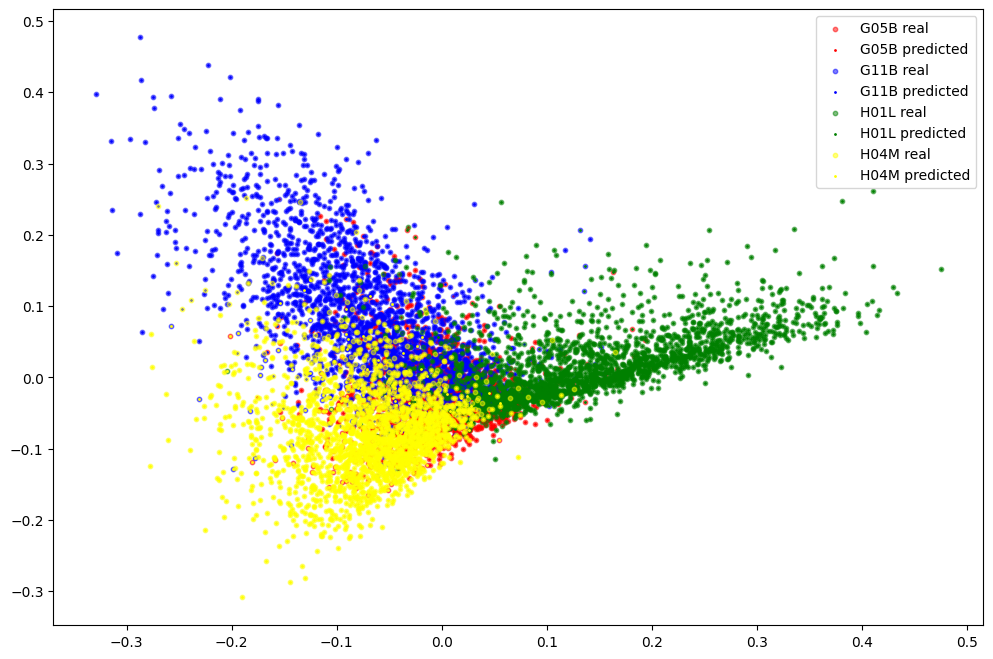

In [12]:
# plot 2d data using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_test_vectors.toarray())

plt.figure(figsize=(12, 8))

for label, color in zip(classes, colors):
    plt.scatter(X_pca[y_test == label, 0], X_pca[y_test == label, 1], label=f"{label} real", alpha=0.5, s=10, c=color)
    plt.scatter(X_pca[y_pred_lr == label, 0], X_pca[y_pred_lr == label, 1], label=f"{label} predicted", alpha=1, s=1, c=color)

plt.legend()
plt.show()

### Topic Extract

In [22]:
# get the top 10 keywords for each cluster
for class_ in np.unique(y_pred_lr):
    print(f"Cluster {class_}")
    print('    ', ' '.join(extract_keywords_lda(X_test[y_pred_lr == class_])))

Cluster G05B
     system data control drawing method description unit device information process
Cluster G11B
     data information medium content device description drawing audio video method
Cluster H01L
     circuit semiconductor method device description drawing integrated layout data first
Cluster H04M
     device information method user terminal mobile data system drawing description


## K-Means Clustering

In [11]:
# Clustering with K-Means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
print("Training the classifier...")
kmeans.fit(X_train_vectors)
print("Evaluating...")
y_pred_km = kmeans.predict(X_test_vectors)
print("Done!")

# Сопоставление кластеров с классами
cluster_labels = {}
for cluster in np.unique(y_pred_km):
    counts = y_test[y_pred_km == cluster].value_counts()
    class_probas = counts / counts.sum()
    print(f"Cluster {cluster} probabilities: {[f'{class_}: {proba:.2f}' for class_, proba in zip(class_probas.index, class_probas.values)]}")
    cluster_labels[cluster] = class_probas.index[0]
y_pred_km = np.array([cluster_labels[cluster] for cluster in y_pred_km])

Training the classifier...
Evaluating...
Done!
Cluster 0 probabilities: ['H04M: 0.46', 'G11B: 0.37', 'G05B: 0.14', 'H01L: 0.03']
Cluster 1 probabilities: ['H01L: 0.97', 'G05B: 0.01', 'G11B: 0.01', 'H04M: 0.00']
Cluster 2 probabilities: ['G05B: 0.33', 'H04M: 0.26', 'G11B: 0.22', 'H01L: 0.18']
Cluster 3 probabilities: ['G11B: 0.47', 'G05B: 0.25', 'H04M: 0.19', 'H01L: 0.09']


In [12]:
print("K-Means Clustering")
print(f"Accuracy: {accuracy_score(y_test, y_pred_km):.2f}")
print(classification_report(y_test, y_pred_km))

K-Means Clustering
Accuracy: 0.45
              precision    recall  f1-score   support

        G05B       0.33      0.79      0.47      2180
        G11B       0.47      0.24      0.32      2147
        H01L       0.97      0.49      0.65      2101
        H04M       0.46      0.27      0.34      2118

    accuracy                           0.45      8546
   macro avg       0.56      0.45      0.45      8546
weighted avg       0.56      0.45      0.45      8546



### Plot

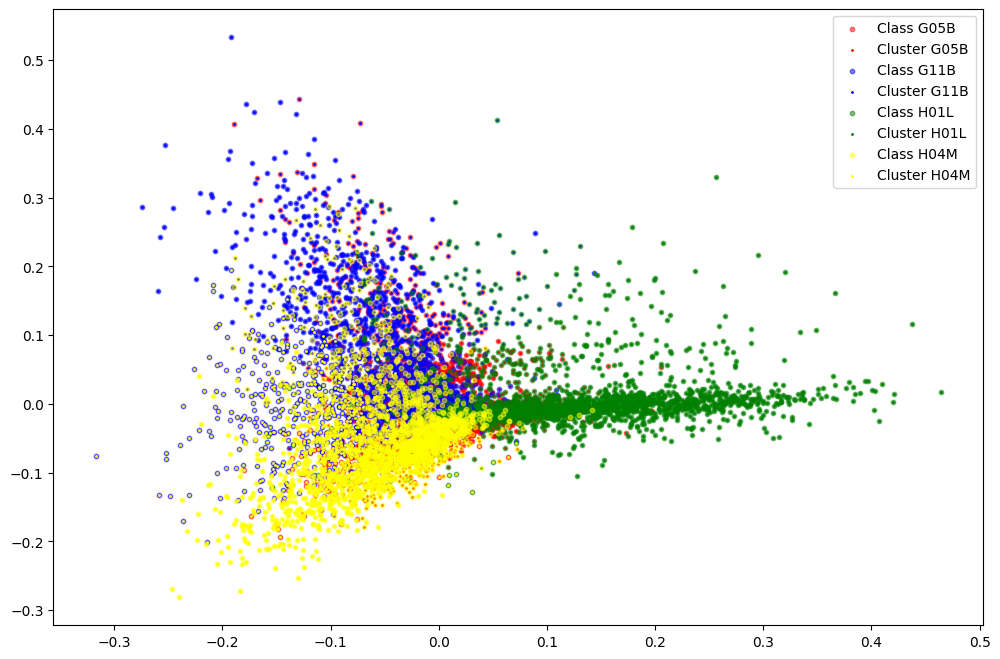

In [13]:
# plot 2d data using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_test_vectors.toarray())
plt.figure(figsize=(12, 8))

for label, color in zip(classes, colors):
    plt.scatter(X_pca[y_test == label, 0], X_pca[y_test == label, 1], c=color, label=f"Class {label}", alpha=0.5, s=10)
    plt.scatter(X_pca[y_pred_km == label, 0], X_pca[y_pred_km == label, 1], c=color, label=f"Cluster {label}", alpha=1, s=1)

plt.legend()
plt.show()

## Topic Extract

In [14]:
# get the top 10 keywords for each cluster
for cluster in np.unique(y_pred_km):
    print(f"Cluster {cluster}")
    print('    ', ' '.join(extract_keywords_tfidf(X_test[y_pred_km == cluster])))

Cluster G05B
     device system control method involves unit signal process based user
Cluster G11B
     device unit recording system file storage processing method information medium
Cluster H01L
     wiring cell layout pattern design device semiconductor logic delay data
Cluster H04M
     content device terminal unit recording apparatus user system processing display
